In [1]:
import pandas as pd
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to C:\Users\madire
[nltk_data]     sathwik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
#load data
file_path = r"D:\NLP\Project\bbc-news-data.csv"

df = pd.read_csv(file_path, sep='\t')


In [3]:
df.shape

(2225, 4)

In [4]:
df.columns

Index(['category', 'filename', 'title', 'content'], dtype='object')

In [5]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [6]:
#rename content=text
df.rename(columns={'content': 'text'}, inplace=True)
df.columns


Index(['category', 'filename', 'title', 'text'], dtype='object')

In [7]:
# Check missing values
df['text'].isnull().sum()


np.int64(0)

In [8]:
# Word count per article
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['word_count'].describe()


count    2225.000000
mean      378.835955
std       238.220755
min        84.000000
25%       240.000000
50%       326.000000
75%       466.000000
max      4428.000000
Name: word_count, dtype: float64

In [9]:
#Sentence Tokenization
from nltk.tokenize import sent_tokenize

df['sentences'] = df['text'].apply(lambda x: sent_tokenize(str(x)))
df['num_sentences'] = df['sentences'].apply(len)

df[['num_sentences']].describe()


,num_sentences
count,2225.000000
mean,18.608090
std,12.719021
min,4.000000
25%,12.000000
50%,16.000000
75%,22.000000
max,248.000000


In [10]:
#Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to C:\Users\madire
[nltk_data]     sathwik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\madire
[nltk_data]     sathwik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\madire
[nltk_data]     sathwik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# Stopword removal Lemmatization A preprocessing function Applied preprocessing to text

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [13]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    
    words = word_tokenize(sentence)   
    
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word.isalpha() and word not in stop_words
    ]
    
    return words


In [14]:
from nltk.tokenize import word_tokenize


In [15]:
sample_sentence = df['text'].iloc[0][:200]

print("Original:", sample_sentence)
print("Processed:", preprocess_sentence(sample_sentence))


Original:  Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google,
Processed: ['quarterly', 'profit', 'u', 'medium', 'giant', 'timewarner', 'jumped', 'three', 'month', 'december', 'firm', 'one', 'biggest', 'investor', 'google']


In [16]:
#Apply to Dataset

from nltk.tokenize import sent_tokenize

df['sentences'] = df['text'].apply(lambda x: sent_tokenize(str(x)))
df['processed_sentences'] = df['sentences'].apply(
    lambda sents: [preprocess_sentence(s) for s in sents]
)


Text preprocessing was performed before summarization. This included stopword removal and lemmatization to reduce noise and normalize word forms, ensuring accurate sentence scoring during summarization.

# Building 
# model 1 Frequency-Based  extractive Summarization  

In [17]:
#importing required libraries
# Frequency-Based Summarizer Function

from collections import defaultdict
from nltk.tokenize import sent_tokenize

def frequency_based_summarizer(text, num_sentences=5):
    sentences = sent_tokenize(text)

    word_freq = defaultdict(int)
    for sentence in sentences:
        for word in preprocess_sentence(sentence):
            word_freq[word] += 1

    sentence_scores = {}
    for i, sentence in enumerate(sentences):
        for word in preprocess_sentence(sentence):
            sentence_scores[i] = sentence_scores.get(i, 0) + word_freq[word]

    # pick top sentence indices
    top_indices = sorted(
        sentence_scores,
        key=sentence_scores.get,
        reverse=True
    )[:num_sentences]

    # restore original order
    top_indices.sort()

    return " ".join([sentences[i] for i in top_indices])


In [18]:
sample_text = df['text'].iloc[0]

print("Original TEXT (first 400 chars):\n")
print(sample_text[:400])
print("\nSUMMARY:\n")

print(frequency_based_summarizer(sample_text, num_sentences=5))

Original TEXT (first 400 chars):

 Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which o

SUMMARY:

Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.

In [19]:

import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt


nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to C:\Users\madire
[nltk_data]     sathwik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\madire
[nltk_data]     sathwik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

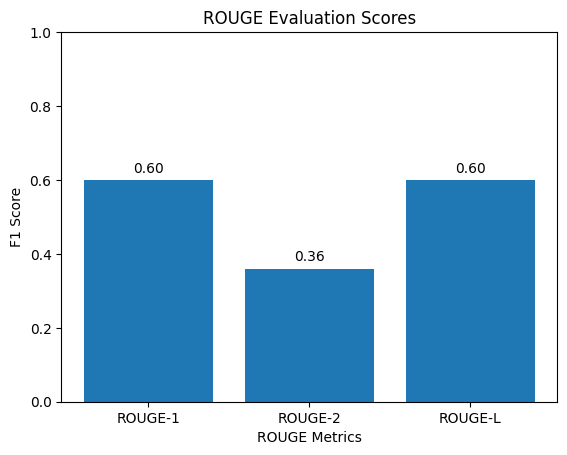

In [20]:
import matplotlib.pyplot as plt

# ROUGE scores from your output
rouge_scores = {
    "ROUGE-1": 0.60,
    "ROUGE-2": 0.36,
    "ROUGE-L": 0.60
}

# Extract labels and values
labels = list(rouge_scores.keys())
values = list(rouge_scores.values())

# Create bar chart
plt.figure()
plt.bar(labels, values)
plt.xlabel("ROUGE Metrics")
plt.ylabel("F1 Score")
plt.title("ROUGE Evaluation Scores")
plt.ylim(0, 1)

# Show values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")

plt.show()
